# Transformer 실습
과제: imdb 데이터 영화평가의 긍부정 이진분류

In [1]:
#이부분 Colab에서 매번마다 돌려야 아래 from datasets import load_dataset 작동이 되는데, notebook에서 않돌리고 진행방법 있을가요?
!pip install datasets sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
import pandas as pd
from torch.nn.utils.rnn import pad_sequence

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


In [3]:
max_len = 400
batch_size=64
d_model=32
n_layers=2
dff = 32
n_heads = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##[My Code] Dataset 내역 살펴보기

In [4]:
ds = load_dataset("stanfordnlp/imdb")  # 영화 리뷰 감정분류 데이터셋 가져옵니다.
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased') # huggingface 의 tokenizer 단어 분석기 로딩

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
print("----------------")
print(texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)[0]) # imdb 첫째 데이터셋을 보기
print("----------------")
for i in range(5):    # imdb 데이터셋 몇개 훌터보기
    print(ds['train'][i])
print("----------------")
print(ds['train'][0]) # imdb 첫째 데이터셋을 보기
for i in range(5):    # imdb label
    print(ds['train'][i]['label'])
print("----------------")
print("text len:",len(ds['train']['text']))
print("label len:",len(ds['train']['label']))
print("----------------")
lab_counts_0 = 0
lab_counts_1 = 0
for i in range(len(ds['train']['label'])):    # imdb label
    if ds['train'][i]['label']==0: lab_counts_0 += 1
    else:lab_counts_1 += 1
print("lab_counts_0:",lab_counts_0)
print("lab_counts_1:",lab_counts_1)

----------------
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes a

In [56]:
df = pd.DataFrame(ds['train'][:])  # Pandas DataFrame
print(df.head())

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


In [58]:
#print(train_loader.dataset)
#print("",ds['train'][0])
#texts = tokenizer(ds['train'][0]['text'], padding=True, truncation=True, max_length=max_len)
#print(texts)

texts = tokenizer(ds['train'][0]['text'], padding=True, truncation=True, max_length=max_len)
print("input_ids:", len(np.array(texts['input_ids'])))
print(np.array(texts['input_ids']),"\n")
print("token_type_ids:",len(np.array(texts['token_type_ids'])))
print(np.array(texts['token_type_ids']),"\n")
print("attention_mask:",len(np.array(texts['attention_mask'])))
print(np.array(texts['attention_mask']),"\n")


input_ids: 363
[  101  1045 12524  1045  2572  8025  1011  3756  2013  2026  2678  3573
  2138  1997  2035  1996  6704  2008  5129  2009  2043  2009  2001  2034
  2207  1999  3476  1012  1045  2036  2657  2008  2012  2034  2009  2001
  8243  2011  1057  1012  1055  1012  8205  2065  2009  2412  2699  2000
  4607  2023  2406  1010  3568  2108  1037  5470  1997  3152  2641  1000
  6801  1000  1045  2428  2018  2000  2156  2023  2005  2870  1012  1026
  7987  1013  1028  1026  7987  1013  1028  1996  5436  2003  8857  2105
  1037  2402  4467  3689  3076  2315 14229  2040  4122  2000  4553  2673
  2016  2064  2055  2166  1012  1999  3327  2016  4122  2000  3579  2014
  3086  2015  2000  2437  2070  4066  1997  4516  2006  2054  1996  2779
 25430 14728  2245  2055  3056  2576  3314  2107  2004  1996  5148  2162
  1998  2679  3314  1999  1996  2142  2163  1012  1999  2090  4851  8801
  1998  6623  7939  4697  3619  1997  8947  2055  2037 10740  2006  4331
  1010  2016  2038  3348  2007  2014

##[Feed back]  
* 데이터 원장에서는 Label 값이 0과 1  각각 25000씩 반반입니다.
* tokenizer 처리된 데이터 구조가 어떤지 알수가 있었습니다.
* token_type_ids 왜서 전부 0으로 되여 있는지 아직 잘 이해가 되지 않습니다.


In [7]:
# collate_fn: 사용자 정의 함수로, 데이터 배치를 처리하는 방식을 정의합니다. 예를 들어, 시퀀스 데이터의 길이를 맞추기 위해 패딩(padding)을 추가하거나, 특정 데이터 형식으로 변환하는 역할을 합니다.
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


# batch_size: 한 번에 모델에 입력되는 데이터 묶음의 크기를 64로 설정합니다. 즉, 훈련 시 한 번의 반복(iteration)에서 처리되는 데이터 개수가 64개입니다.
# shuffle:  데이터를 매 epoch(훈련 반복 주기)마다 무작위로 섞습니다. 이를 통해 모델이 데이터 순서에 의한 학습 편향을 피할 수 있습니다.
train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

print(train_loader)

In [8]:
print(len(train_loader))

391


##[My code] 과정해석
1. IMDB 데이터셋을 로드합니다.
2. Hugging Face의 사전 학습된 BERT 토크나이저를 사용하여 텍스트 데이터를 모델이 사용할 수 있는 입력 형식으로 변환합니다.
3. 데이터를 배치(batch) 단위로 정리하기 위한 커스텀 정리 함수(collate_fn)를 정의합니다.
4. PyTorch의 DataLoader를 사용하여 데이터셋을 반복 가능한 데이터 배치로 설정함.


## Self-attention

이번에는 self-attention을 구현해보겠습니다.
Self-attention은 shape이 (B, S, D)인 embedding이 들어왔을 때 attention을 적용하여 새로운 representation을 만들어내는 module입니다.
여기서 B는 batch size, S는 sequence length, D는 embedding 차원입니다.
구현은 다음과 같습니다.

In [9]:
from torch import nn
from math import sqrt

class MultiHeadAttention(nn.Module):
  def __init__(self, input_dim, d_model,n_heads):  #SelfAttention 에 대한 정의
    super().__init__()
    self.n_heads = n_heads
    self.input_dim = input_dim   #입력 차원
    self.d_model = d_model       #출력 차원
    self.depth = d_model // n_heads  #전체 모델의 차원 에서 head 수로 나눈 차원

    self.wq = nn.Linear(input_dim, d_model)   #Qurey
    self.wk = nn.Linear(input_dim, d_model)   #Key
    self.wv = nn.Linear(input_dim, d_model)   #Velue
    self.dense = nn.Linear(d_model, d_model)  # 최종결과를 추출할 Victer 변환

    self.softmax = nn.Softmax(dim=-1)


  def forward(self, x, mask):
      batch_size, max_len, _ = x.shape  # 입력 텐서의 배치 크기

      # Query, Key, Value 생성
      q = self.wq(x)  # 초기형태 (batch_size, seq_len, d_model)
      k = self.wk(x)  # 초기형태 (batch_size, seq_len, d_model)
      v = self.wv(x)  # 초기형태 (batch_size, seq_len, d_model)

      # Reshape: 각 Head로 나누기
      q = q.view(batch_size, max_len, self.n_heads, self.depth)  # 변경후 형태 (batch_size, seq_len, n_heads, depth)
      k = k.view(batch_size, max_len, self.n_heads, self.depth)  # 변경후 형태 (batch_size, seq_len, n_heads, depth)
      v = v.view(batch_size, max_len, self.n_heads, self.depth)  # 변경후 형태 (batch_size, seq_len, n_heads, depth)

      # Transpose: Head 차원을 앞으로 이동 (seq_len과 n_heads 위치 교환)
      # 목적: Multi-Head Attention에서 각 헤드가 독립적으로 연산할 수 있도록 n_heads를 배치 차원(batch_size) 바로 뒤로 이동.
      q = q.transpose(1, 2)  # (batch_size, n_heads, seq_len, depth)
      k = k.transpose(1, 2)  # (batch_size, n_heads, seq_len, depth)
      v = v.transpose(1, 2)  # (batch_size, n_heads, seq_len, depth)

      # Scaled Dot-Product Attention 계산
      score = torch.matmul(q, k.transpose(-1, -2)) / sqrt(self.depth)  # (batch_size, n_heads, seq_len, seq_len)

      if mask is not None:
        # mask shape: (batch, 1, 1, length)
        # softmax에 매우 작은 값이 마스킹에 들어가면 관련성이 없다고 판단하여
        # 마스킹된 부분이 관련성 계산에서 배제되는 결과를 만듭니다.
        score = score + (mask * -1e9)
      score = self.softmax(score)


      attention_weights = self.softmax(score)  # Attention Weight 계산
      context = torch.matmul(attention_weights, v)  # Attention 값 계산 (batch_size, n_heads, seq_len, depth)

      # Transpose: 원래 순서로 복원
      context = context.transpose(1, 2)  # (batch_size, seq_len, n_heads, depth)

      # Reshape: Head 차원을 합치기
      context = context.contiguous().view(batch_size, max_len, self.d_model)  # (batch_size, seq_len, d_model)

      # 최종 Dense 레이어 적용
      output = self.dense(context)  # (batch_size, seq_len, d_model)

      return output  # SelfAttention matrix

In [10]:
class TransformerLayer(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, dff):
        super().__init__()

        # Multi-head Attention
        self.mha = MultiHeadAttention(input_dim, d_model, n_heads)

        # Feedforward Neural Network (FFN)  여기에 대해서 좀더 자료를 찾아볼 필요가 있습니다.
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),  # 첫 번째 Linear Layer
            nn.ReLU(),                # 비선형 활성화 함수
            nn.Linear(dff, d_model)   # 두 번째 Linear Layer
        )

        # Layer Normalization
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)

        # Dropout (optional)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x, mask):
        # Multi-head Attention
        attn_output = self.mha(x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)

        # Residual Connection + Layer Normalization
        out1 = self.layernorm1(x + attn_output)  # (batch_size, seq_len, d_model)

        # Feedforward Network
        ffn_output = self.ffn(out1)  # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)

        # Residual Connection + Layer Normalization
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, seq_len, d_model)

        return out2



## Positional encoding


In [11]:
import numpy as np

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)

print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


#[Feedback]
Positional encoding 부분은 아직까지 이해가 잘 않되서 코드를 그대로 가져와 쓰고 별도로 다시 학습해볼 예정입니다.

Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

In [12]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, n_heads, dff):
    super().__init__()

    self.vocab_size = vocab_size   #text 단어수량
    self.d_model = d_model         #임베딩과 특성 표현의 차원
    self.n_layers = n_layers       #Transformer 층 수량
    self.dff = dff                 #피드포워드 신경망의 은닉층 차원

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)

    #여러 Transformer 레이어를 묶는 데 사용됩니다
    #각각의 레이어는 TransformerLayer로 구성되며
    #입력과 출력의 특성 차원은 d_model입니다.
    #전방 전달 신경망의 은닉층 차원은 dff입니다
    #n_layers는 Transformer 레이어의 수를 결정합니다.
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, n_heads, dff) for _ in range(n_layers)])

    #완전 연결 계층으로, 분류 작업에 사용됩니다.
    #출력 계층을 1로 부터 사전 크기로 바꾸었습니다.
    self.classification = nn.Linear(d_model,self.vocab_size)

  #X의 형태는(B, S)  B:batch,  S:시퀀스 len
  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, None, :]  # 차원의 증가  (B, S) ->  (B, 1, 1, S)
    seq_len = x.shape[1]

    x = self.embedding(x)   #입력 토큰 ID를 임베딩 벡터로 변환,  (B, S)에서 (B, S, d_model)로 변경
    x = x * sqrt(self.d_model)  # 임베딩 값이 지나치게 작아지는 것을 방지
    x = x + self.pos_encoding[:, :seq_len] # 상대위치를 설정함

    #다층의 Transformer  ,  출력형태: (B, S, d_model)
    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]  #전 행의 대표하는 첫째 토큰만 classifier에 넣습니다.
    x = self.classification(x)

    return x


#model = TextClassifier(len(tokenizer), 32, 2, 32)
model = TextClassifier(
        vocab_size=len(tokenizer),  # bert-base-uncased 의  30,522 개 단어의 토큰
        d_model=d_model,
        n_layers=n_layers,
        n_heads = n_heads,
        dff=dff
)
model = model.to(device)

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

In [65]:
pip install torchinfo

In [66]:
from torchinfo import summary
# 모델 정보 출력
summary(model, input_size=(batch_size, max_len), dtypes=[torch.int64])

Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [64, 30522]               12,800
├─Embedding: 1-1                         [64, 400, 32]             976,704
├─ModuleList: 1-2                        --                        --
│    └─TransformerLayer: 2-1             [64, 400, 32]             --
│    │    └─MultiHeadAttention: 3-1      [64, 400, 32]             4,224
│    │    └─Dropout: 3-2                 [64, 400, 32]             --
│    │    └─LayerNorm: 3-3               [64, 400, 32]             64
│    │    └─Sequential: 3-4              [64, 400, 32]             2,112
│    │    └─Dropout: 3-5                 [64, 400, 32]             --
│    │    └─LayerNorm: 3-6               [64, 400, 32]             64
│    └─TransformerLayer: 2-2             [64, 400, 32]             --
│    │    └─MultiHeadAttention: 3-7      [64, 400, 32]             4,224
│    │    └─Dropout: 3-8                 [64, 400, 32]             

## 학습

In [13]:
from torch.optim import Adam

lr = 0.001
loss_fn = nn.BCEWithLogitsLoss().to(device)
#loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device).long()

    preds = model(inputs)
    #preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [15]:
n_epochs = 50
train_accs = []
test_accs =[]
total_losses = []

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    for data in train_loader:
      model.zero_grad()
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device).float()

      preds = model(inputs)[..., 0]
      loss = loss_fn(preds, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

    with torch.no_grad():
      model.eval()
      train_acc = accuracy(model, train_loader)
      test_acc = accuracy(model, test_loader)
      print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
      train_accs.append(train_acc)
      test_accs.append(test_acc)
      total_losses.append(total_loss)



Epoch   0 | Train Loss: 246.8614937365055
=========> Train acc: 0.790 | Test acc: 0.767
Epoch   1 | Train Loss: 151.62906023859978
=========> Train acc: 0.879 | Test acc: 0.835
Epoch   2 | Train Loss: 116.67439853399992
=========> Train acc: 0.890 | Test acc: 0.833
Epoch   3 | Train Loss: 98.4254783987999
=========> Train acc: 0.918 | Test acc: 0.849
Epoch   4 | Train Loss: 85.89560943096876
=========> Train acc: 0.936 | Test acc: 0.861
Epoch   5 | Train Loss: 75.53363736718893
=========> Train acc: 0.949 | Test acc: 0.863
Epoch   6 | Train Loss: 65.05326402559876
=========> Train acc: 0.939 | Test acc: 0.852
Epoch   7 | Train Loss: 58.24518349021673
=========> Train acc: 0.968 | Test acc: 0.859
Epoch   8 | Train Loss: 49.89426966197789
=========> Train acc: 0.970 | Test acc: 0.854
Epoch   9 | Train Loss: 44.24873778410256
=========> Train acc: 0.974 | Test acc: 0.850
Epoch  10 | Train Loss: 39.0440897801891
=========> Train acc: 0.983 | Test acc: 0.856
Epoch  11 | Train Loss: 35.28583

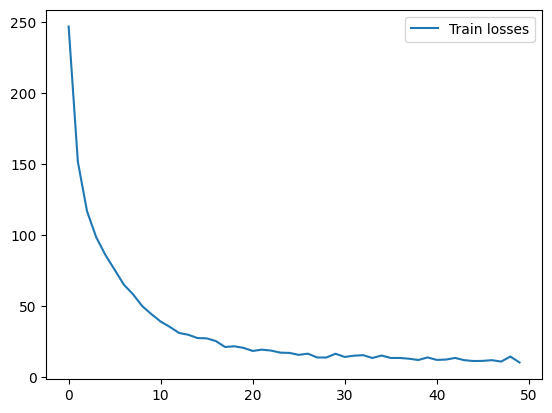

In [21]:
def plot_losses(total_losses, label1='train'):
  x = np.arange(len(total_losses))

  plt.plot(x, total_losses, label=label1)
  plt.legend()
  plt.show()
plot_losses(total_losses, label1='Train losses')

In [16]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

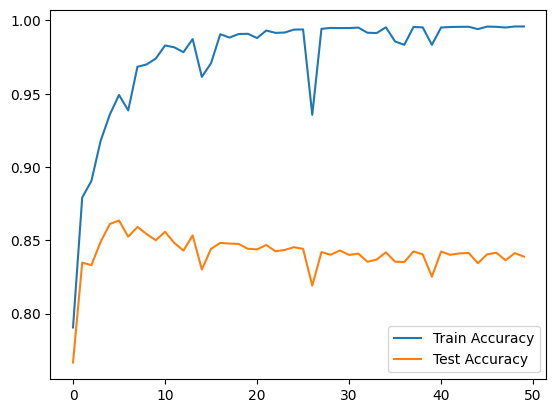

In [19]:
plot_acc(train_accs, test_accs, label1='Train Accuracy', label2='Test Accuracy')

##[Conclusion]
*   Training 에서 학습이 10회 배치까지 정확도 가파롭게 오르다  90프로 근처에서 속도가 늦져집니다.   거의 98% 까지 정확도를 유지하고 있는걸 볼수가 있습니다.
*   Test 에서 5회 배치까지 정확도 가파롭게 오르면서 86% 가까이로부터 정확도가 다이상 올라가지 않고 85% 가까이에서 유지고 되고 있습니다.
*   Test 결과가 Training 보다 항상 20프로 정도 낮습니다.





##[My Code] Prediction 실행 및 직관적인 결과보기
Encoding 부분만이라서 예측값이 오로지 token code 로 보이는걸로 이해를 하고 있습니다.

In [63]:
for data in train_loader:
      model.zero_grad()
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device).float()
      print("inputs: ", len(inputs)," \n",inputs)

      print("================================")
      preds = model(inputs)[..., 0]
      print("preds:  ", len(inputs)," \n",preds)
      break;


inputs:  64  
 tensor([[ 101, 3452, 2023,  ...,    0,    0,    0],
        [ 101, 1037, 2155,  ...,    0,    0,    0],
        [ 101, 1026, 7987,  ...,    0,    0,    0],
        ...,
        [ 101, 1045, 2074,  ..., 2131, 1037,  102],
        [ 101, 2442, 2296,  ...,    0,    0,    0],
        [ 101, 2066, 1996,  ...,    0,    0,    0]], device='cuda:0')
preds:   64  
 tensor([-5.5425, -7.6235, -7.7481, -6.3531,  6.8354, -7.7564,  4.4562,  5.6342,
         5.5673,  5.3106, -5.8833,  4.9142,  6.6387, -7.5223, -7.7517, -7.2509,
         6.6107,  6.2319, -6.9035,  4.2660, -7.6145, -6.9587,  4.8630, -7.4692,
         4.9308, -7.6875, -7.3461, -7.7174,  5.8389,  5.5485,  4.5835,  6.5283,
         6.9930,  4.5057,  5.5435,  7.0300,  6.0192,  5.6140, -7.6581,  5.6289,
        -5.2127,  7.0143, -7.5851, -7.7036,  4.3923,  7.0748, -7.1960, -5.6750,
        -7.7102,  7.1355,  4.6699,  5.4323,  4.4783, -6.7893, -6.3600,  4.3198,
         4.9635,  4.2565, -5.5323, -7.7351,  7.1645,  5.8679, -7.69